# Example 3: Inference

In this example, we will combine the variational diffusion model (VDM) and the flows from the previous two examples to perform inference. 

From the simulation parameters, i.e. $\{m_\mathrm{WDM}, A_\mathrm{SN1}, A_\mathrm{SN2}, A_\mathrm{AGN}\}$, we will generate the number of satellites $N_\mathrm{sat}$ using the flows.
Using the VDM, we will generate the satellite galaxies, including their positions, velocities, masses, and concentration proxies. 

In [124]:
import os
import sys

# replace this with the path to the nehod_torch repository
sys.path.append('/path/to/your/nehod_torch')

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import zuko
from torch.utils.data import DataLoader, TensorDataset

import datasets
from nehod import noise_schedules, scores
from nehod.diffusion_utils import alpha, sigma2, variance_preserving_map

%matplotlib inline

## Read in the models

First, we will read in the models.

We will have to redefine the diffusion model and the flows to import the trained models. 
We only have to do this because we did not modularize the code in the previous examples.
If we are using the `nehod`, we will simply import them from `vdm.py` and `flows.py`.

In [24]:
def latent_loss(x, gamma_fn, device=None):
    """ KL divergence between posterior and prior. Prior matching term.

    Parameters
    ----------
    x : The data.
    gamma_fn: The noise scheduler. 
    """
    g_1 = gamma_fn(torch.tensor([1.0], device=device))
    var_1 = sigma2(g_1)
    mean1_sqr = (1 - var_1) * torch.square(x)
    loss_klz = 0.5 * (mean1_sqr + var_1 - torch.log(var_1) - 1.0)
    return loss_klz

def recon_loss(x, gamma_fn, device=None):
    """ Compute the reconstruction loss. Defined as the negative log-likelihood
    of the data under the model.

    Parameters
    ----------
    x : The data.
    gamma_fn: The noise scheduler.
    """
    g_0 = gamma_fn(torch.tensor([0.0], device=device))
    eps_0 = torch.randn_like(x)
    z_0 = variance_preserving_map(x, g_0, eps_0)
    z_0_rescaled = z_0 / alpha(g_0)
    loss_recon = -dist.Normal(loc=z_0_rescaled, scale=1e-3).log_prob(x)
    return loss_recon

def diffusion_loss(t, x, gamma_fn, score_model, cond=None, mask=None, timesteps=0, device=None):
    """ Compute the diffusion loss.

    Parameters
    ----------
    t : The diffusion time.
    x : The data.
    gamma_fn: The noise scheduler.
    cond : The conditioning data.
    mask : The mask for padded data.
    timesteps : The number of diffusion timesteps. Set to 0 for continuous time.
    """
    # Sample z_t
    g_t = gamma_fn(t)
    eps = torch.randn_like(x)
    z_t = variance_preserving_map(x, g_t[:, None], eps)

    # Compute predicted noise and the MSE
    eps_hat = score_model(z_t, g_t, cond, mask)
    deps = eps - eps_hat
    loss_diff_mse = torch.square(deps)  # Compute MSE of predicted noise

    if timesteps == 0:
        # Loss for infinite depth T, i.e. continuous time
        g_t_grad = torch.autograd.grad(
            g_t, t,
            grad_outputs=torch.ones_like(g_t),
            create_graph=True,
            retain_graph=True,
        )[0]
        loss_diff = -0.5 * g_t_grad[:, None, None] * loss_diff_mse
    else:
        # Loss for finite depth T, i.e. discrete time
        s = t - (1.0 / timesteps)
        g_s = gamma_fn(s)
        loss_diff = 0.5 * timesteps * torch.expm1(g_s - g_t)[:, None, None] * loss_diff_mse
    return loss_diff

# Define a diffusion model with a Transformer-based noise model
class DiffusionModel(pl.LightningModule):
    def __init__(self, norm_dict):
        super().__init__()
        # Lightning allows extra information to be saved in with the model
        # this is a convenient way to save the normalization statistics
        self.norm_dict = norm_dict
        self.save_hyperparameters()

        # define the noise scehduler
        self.gamma_fn = noise_schedules.NoiseScheduleScalar(-16.0, 10.0)

        # define the score model
        # note that since we are using context embedding
        self.score_model = scores.TransformerScoreModel(
            9,  # number of generated features
            d_cond=16,  # number of conditioning features
            d_t_embedding=16, 
            score_dict=dict(
                d_model=256, d_mlp=512, n_layers=6, n_heads=4
            )
        )

        # context embedding
        self.embedding = nn.Linear(5, 16)

    def _sample_timesteps(self, batch_size, timesteps):
        t0 = torch.rand(batch_size)
        t_n = torch.remainder(
        t0 + torch.arange(0.0, 1.0, step=1.0 / batch_size), 1.0)

        # discretize time steps if we're working with discrete time
        if timesteps > 0:
            t_n = torch.ceil(t_n * timestels) / timesteps

        return t_n

    def forward(self, x, conditioning=None, mask=None, timesteps=0):
        # forward pass
        batch_size = x.shape[0]

        # 1. Reconstruction loss
        loss_recon = recon_loss(x, self.gamma_fn, device=self.device)

        # 2. Latent loss
        loss_klz = latent_loss(x, self.gamma_fn, device=self.device)

        # 3. Diffusion loss
        t = self._sample_timesteps(batch_size, timesteps).requires_grad_(True)
        t = t.to(self.device)
        cond = self.embedding(conditioning)
        loss_diff = diffusion_loss(
            t, x, self.gamma_fn, self.score_model, 
            cond, mask, timesteps, device=x.device)

        return loss_recon, loss_klz, loss_diff

    def prepare_batch(self, batch):
        # Convienence function to prepare the batch
        x, conditioning, mask = batch

        # move to the same device as the model
        x = x.to(self.device)
        conditioning = conditioning.to(self.device)
        mask = mask.to(self.device)

        # data augmentation step
        # apply rotational augmentations to the data by rotating the 3D positions
        # and 3D velocities by a random angle
        x = augmentations.augment_with_symmetries(x, 3, 3, device=self.device)

        return {
            'x': x,
            'conditioning': conditioning,
            'mask': mask,
            'batch_size': x.shape[0],
        }

    def vdm_loss(self, x, conditioning=None, mask=None):
        # Conviencence function to compute the loss
        loss_diff, loss_klz, loss_recon= self.forward(x, conditioning, mask)

        if mask is None:
            mask = torch.ones(x.shape[:-1])
        else:
            # reverse mask because of torch convention
            mask = torch.logical_not(mask).type_as(x)
        loss_batch = (
            ((loss_diff + loss_klz + loss_recon) * mask[:, :, None]).sum((-1, -2))
        ) / mask.sum(-1)
        return loss_batch.mean()

    def training_step(self, batch, batch_idx):
        # Training step, this is required by PyTorch Lightning
        batch_dict = self.prepare_batch(batch)
        loss = self.vdm_loss(
            batch_dict['x'], batch_dict['conditioning'], batch_dict['mask'])
        self.log(
            'train_loss', loss, on_step=True, on_epoch=True,
            batch_size=batch_dict['batch_size'])
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step, this is required by PyTorch Lightning
        batch_dict = self.prepare_batch(batch)
        with torch.enable_grad():
            # need to enable grad for the score model
            loss = self.vdm_loss(
                batch_dict['x'], batch_dict['conditioning'], batch_dict['mask'])
        self.log(
            'val_loss', loss, on_step=True, on_epoch=True,
            batch_size=batch_dict['batch_size'])
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)
        return optimizer

class NPE(pl.LightningModule):
    def __init__(self, norm_dict=None):
        super().__init__()
        # Lightning allows extra information to be saved in with the model
        # this is a convenient way to save the normalization statistics
        self.norm_dict = norm_dict
        self.save_hyperparameters()

        # hyperparameters of the flows as defined in `configs/example_flows.py`
        context_dim = 4
        in_dim = 1
        num_transforms = 4
        projection_dims = [32, 32]
        hidden_dims = [16, 16, 16, 16]
        dropout = 0.1

        self.lin_proj_layers = nn.ModuleList()
        for i in range(len(projection_dims)):
            in_proj_dim = context_dim if i == 0 else projection_dims[i - 1]
            out_proj_dim = projection_dims[i]
            self.lin_proj_layers.append(nn.Linear(in_proj_dim, out_proj_dim))
            self.lin_proj_layers.append(nn.ReLU())
            self.lin_proj_layers.append(nn.BatchNorm1d(out_proj_dim))
            self.lin_proj_layers.append(nn.Dropout(dropout))
        self.lin_proj_layers = nn.Sequential(*self.lin_proj_layers)
        self.flow = zuko.flows.NSF(
            in_dim, projection_dims[-1], transforms=num_transforms,
            hidden_features=hidden_dims, randperm=True
        )

    def forward(self, context):
        embed_context = self.lin_proj_layers(context)
        return embed_context

    def training_step(self, batch, batch_idx):
        target, context = batch
        embed_context = self.forward(context)
        loss = -self.flow(embed_context).log_prob(target).mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, batch_size=target.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        target, context = batch
        embed_context = self.forward(context)
        loss = -self.flow(embed_context).log_prob(target).mean()
        self.log('val_loss', loss, on_step=True, on_epoch=True, batch_size=target.size(0))
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)
        return optimizer

In [39]:
# loading checkpoint and map to the same device
# note that if you're using the same seed as in the previous notebook, the val_loss will be the same
# as the one here. If you're using a different seed, the val_loss will be different
# and you'll need to adjust the path to the checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
diffusion_model = DiffusionModel.load_from_checkpoint(
    'output/diffusion/lightning_logs/checkpoints/epoch=249-val_loss=135.0540.ckpt',
    map_location=device)
flow_model = NPE.load_from_checkpoint(
    'output/flows/lightning_logs/checkpoints/epoch=249-val_loss=0.3696.ckpt',
    map_location=device)

# make sure that the models are in evaluation mode
diffusion_model.eval()
flow_model.eval()

# load the normalization statistics
norm_dict = diffusion_model.norm_dict
flow_norm_dict = flow_model.norm_dict

## Generate new samples

We will start by sampling from the flows to generate the number of satellites $N_\mathrm{sat}$. The syntax is the same as in the previous example.

In [55]:
# set seed for reproducibility
pl.seed_everything(55)

# generation parameters
n_samples = 1000  # number of flows_samples to generate
max_num_sats = 50 # maximum number of satellites

Seed set to 55


In [50]:
# Sample new conditioning features (or context) from the prior distribution
context_min = np.array(
    [1/30, np.log10(0.9), np.log10(3.7), np.log10(0.025)])
context_max = np.array(
    [1/1.8, np.log10(14.4), np.log10(14.8), np.log10(0.4)])
context = np.random.uniform(context_min, context_max, size=(n_samples, 4))

# normalized and convert to tensor
context_norm = (context - flow_norm_dict['cond_mean']) / flow_norm_dict['cond_std']
context_norm = torch.tensor(context_norm, dtype=torch.float32)
context_norm = context_norm.to(device)

with torch.no_grad():
    flow_context = flow_model(context_norm)
    log_num_sats = flow_model.flow(flow_context).sample()
    log_num_sats = log_num_sats.cpu().numpy()

# rescale the log_num_sats to the original scale
log_num_sats = log_num_sats * flow_norm_dict['target_std'] + flow_norm_dict['target_mean']

Since the flows predict $\log_{10}(N_\mathrm{sat})$, we will convert the samples to $N_\mathrm{sat}$ and round them to the nearest integer. This is only required to create a padding mask for the VDM. 

In [87]:
num_sats = np.round(10**log_num_sats)
# clip the number of satellites to the maximum number of satellites
num_sats = np.clip(num_sats, 0, max_num_sats)

# functions to create mask from `nehod/eval.py`
# as a reminder, this is using the Jax convention, with False is the padded data
def create_mask(n_array, num_particles):
    """
    Create a mask of shape (len(n_array), num_particles) where for each row i,
    the first n_array[i] elements are 1, and the rest are 0.
    """
    # Create an array of indices [0, 1, 2, ..., num_particles-1]
    indices = np.arange(num_particles)

    # Use broadcasting to create the mask
    masks = indices < n_array[:, None]

    return masks

mask = create_mask(num_sats.reshape(-1), max_num_sats)
np.testing.assert_equal(mask.sum(axis=1), num_sats.reshape(-1))  # check if the mask is correct

# reverse the mask to match the Pytorch convention
mask = ~mask

In the next steps, we will create the conditioning features for the VDM and create the data loader.

In [115]:
diffusion_context = np.hstack([context, log_num_sats])
diffusion_context_norm = (diffusion_context - norm_dict['cond_mean']) / norm_dict['cond_std']

In [116]:
# convert to tensor
diffusion_context_norm = torch.tensor(diffusion_context_norm, dtype=torch.float32)
mask = torch.tensor(mask, dtype=torch.bool)

data_loader = datasets.create_dataloader(
    (diffusion_context_norm, mask), batch_size=64,
    shuffle=True, pin_memory=torch.cuda.is_available())

/tmp/ipykernel_2221107/300810260.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.bool)


We can now start sampling from the VDM. We will reuse the functions from Example 1.

In [122]:
@torch.no_grad()
def sample_step(model, z_t, i, T, conditioning=None, mask=None):
    """ Sample a step of the diffusion process.
    Parameters
    ----------
    z_t : torch.Tensor
        Latent state at time t, where t = (T - i) / T.
    i : int
        Current time step.
    T : int
        Total number of time steps.
    cond : torch.Tensor, optional
        Conditioning information.
    mask : torch.Tensor, optional
        Mask for the diffusion process.
    Returns
    -------
    z_s : torch.Tensor
        Latent state at time s, where s = t - 1.
    """
    eps = torch.randn_like(z_t)
    t = (T - i) / T
    s = (T - i - 1) / T
    g_t = model.gamma_fn(t)
    g_s = model.gamma_fn(s)
    cond = model.embedding(conditioning)
    eps_hat_cond = model.score_model(
        z_t,
        g_t * torch.ones(z_t.shape[0], dtype=z_t.dtype, device=z_t.device),
        cond,
        mask
    )
    a = F.sigmoid(g_s)
    b = F.sigmoid(g_t)
    c = -torch.expm1(g_t - g_s)
    sigma_t = torch.sqrt(sigma2(g_t))
    z_s = (
        torch.sqrt(a / b) * (z_t - sigma_t * c * eps_hat_cond)
        + torch.sqrt((1.0 - a) * c) * eps
    )
    return z_s

def generate_batch(
    model, cond=None, mask=None, num_sampling_steps=1000, num_particles=50,
    num_features=9, batch_size=None, device='cuda'):
    """ Generate VDM samples from a single batch """
    if cond is None and batch_size is None:
        raise ValueError("If unconditional, batch_size must be given")
    batch_size = cond.shape[0] if cond is not None else batch_size

    # random noise from N(0, 1)
    z_t = torch.randn((batch_size, num_particles, num_features), device=device)
    for i in torch.arange(0, num_sampling_steps):
        # denoising step
        z_t = sample_step(
            model, z_t, i, num_sampling_steps, conditioning=cond, mask=mask)
    g0 = model.gamma_fn(0.0)
    var0 = sigma2(g0)
    z_0_rescaled = z_t / torch.sqrt(1.0 - var0)
    return z_0_rescaled

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    generated_samples = []
    generated_mask = []
    generated_cond = []
    for batch in data_loader:
        cond_val = batch[0].to(device)
        mask_val = batch[1].to(device)
        # reuse the conditioning features and padding mask from the dataset
        samples = generate_batch(
            diffusion_model, cond_val, mask_val, num_sampling_steps=500, num_particles=50,
            num_features=9, device=device)
        generated_samples.append(samples.cpu().numpy())
        generated_mask.append(mask_val.cpu().numpy())
        generated_cond.append(cond_val.cpu().numpy())
    generated_samples = np.concatenate(generated_samples, axis=0)
    generated_mask = np.concatenate(generated_mask, axis=0)
    generated_cond = np.concatenate(generated_cond, axis=0)

# Re-scale the generated samples back to physical units
generated_samples = generated_samples * norm_dict['x_std'] + norm_dict['x_mean']
generated_cond = generated_cond * norm_dict['cond_std'] + norm_dict['cond_mean']

# Note that the generated samples also include the padded values, so we need to remove them
# we can simply set them to NaN so they don't show up in the plots
generated_samples = np.where(~generated_mask[..., None], generated_samples, np.nan)

## Comparison with the simulations.

Finally, we will compare the generated samples with the simulations. First, we will read in the simulations.

In [138]:
conditioning_parameters = ['inv_wdm_mass', 'log_sn1','log_sn2','log_agn1', 'log_num_subhalos']
sim_samples, sim_cond, sim_mask, norm_dict = datasets.read_preprocess_dataset(
    data_root='data', data_name='example', flag=None,
    conditioning_parameters=conditioning_parameters, 
    invert_mask=True, norm_data=False, return_numpy=True
)

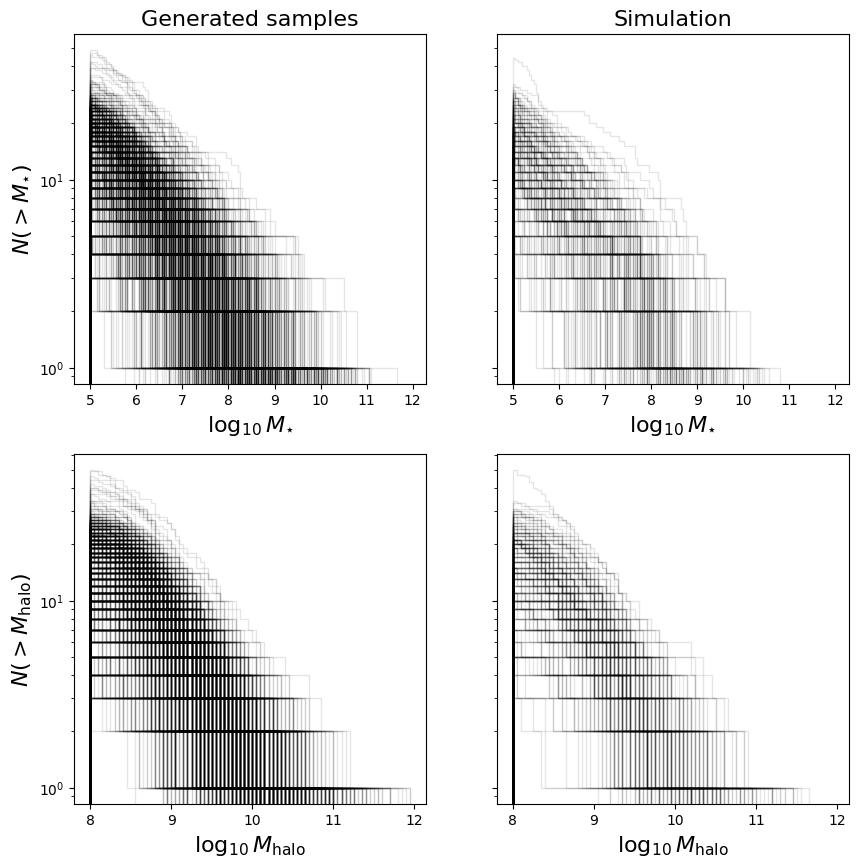

In [140]:
# Plot the satellite stellar and halo mass function
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex='row', sharey='row')

# Plot the mass function
for i in range(len(generated_samples)):
    # stellar mass function
    bins = np.arange(5, 12, 0.05)
    axes[0, 0].hist(
        generated_samples[i, :, 7], histtype='step', 
        bins=bins, color='black', alpha=0.1, cumulative=-1)
    
    # halo mass function
    bins = np.arange(8, 12, 0.05)
    axes[1, 0].hist(
        generated_samples[i, :, 6], histtype='step', 
        bins=bins, color='black', alpha=0.1, cumulative=-1)

for i in range(len(sim_samples)):
    bins = np.arange(5, 12, 0.05)
    axes[0, 1].hist(
        sim_samples[i, :, 7], histtype='step',
        bins=bins, color='black', alpha=0.1, cumulative=-1)
    bins = np.arange(8, 12, 0.05)
    axes[1, 1].hist(
        sim_samples[i, :, 6], histtype='step',
        bins=bins, color='black', alpha=0.1, cumulative=-1)

axes[0, 0].set_yscale('log')
axes[1, 0].set_yscale('log')
axes[0, 0].set_title('Generated samples', fontsize=16)
axes[0, 1].set_title('Simulation', fontsize=16)
axes[0, 0].set_xlabel(r'$\log_{10} M_{\star}$', fontsize=16)
axes[0, 1].set_xlabel(r'$\log_{10} M_{\star}$', fontsize=16)
axes[1, 0].set_xlabel(r'$\log_{10} M_\mathrm{halo}$', fontsize=16)
axes[1, 1].set_xlabel(r'$\log_{10} M_\mathrm{halo}$', fontsize=16)
axes[0, 0].set_ylabel(r'$N(>M_{\star})$', fontsize=16)
axes[1, 0].set_ylabel(r'$N(>M_\mathrm{halo})$', fontsize=16)

plt.show()

## Under Construction: More detailed analysis